In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import torch.nn.functional as F
from tqdm import tqdm
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from collections import Counter
import warnings


warnings.filterwarnings("ignore")

c:\Users\abhij\AppData\Local\Programs\Python\Python39\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\abhij\AppData\Local\Programs\Python\Python39\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        attn_weights = F.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context, attn_weights

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.attention = Attention(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, (hidden, _) = self.lstm(embedded)
        context, attn_weights = self.attention(lstm_output)
        hidden = self.dropout(context)
        hidden = torch.relu(self.fc1(hidden))
        output = self.fc2(hidden)
        return output

In [3]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def tokenize_text(text):
    tokens = text.split()
    return [glove.stoi[token] for token in tokens if token in glove.stoi]


def clean_digits(text):
    flag = True
    for word in text.split():
        if(word.isdigit() == False):
            return text
            flag = False
    
    if(flag):
        return None

In [4]:
file_path = 'D:\\BSES - Data Analyst\\Sentiment Analysis\\Data\\Roberta Data.csv'
df = pd.read_csv(file_path)
df['Customer_Text'] = df['Customer_Text'].astype(str)
print()
df

,Customer_Text,Sentiment
0,i am very shocked due to my electricity bill l...,negative
1,can we know about the new baseguidelines about...,negative
2,it is third day of low voltage fluctuation in ...,negative
3,now that 30620 is over lab test must have be d...,neutral
4,no power supply in our area since last 30 min ...,negative
...,...,...
34604,heres no electrical supply qhy you cut the ele...,negative
34605,no power for ca no 151791523,negative
34606,no electricity in our area my ca no is 101424877,negative
34607,still no update when would be power restored,negative


In [5]:
df['Customer_Text'] = df['Customer_Text'].apply(clean_digits)
df.dropna(inplace=True)
df['Customer_Text'] = df['Customer_Text'].apply(clean_text)
df = df[df['Customer_Text'].str.strip() != '']
df = df[df['Customer_Text'].str.split().apply(len) > 1]
df

,Customer_Text,Sentiment
0,i am very shocked due to my electricity bill l...,negative
1,can we know about the new baseguidelines about...,negative
2,it is third day of low voltage fluctuation in ...,negative
3,now that 30620 is over lab test must have be d...,neutral
4,no power supply in our area since last 30 min ...,negative
...,...,...
34604,heres no electrical supply qhy you cut the ele...,negative
34605,no power for ca no 151791523,negative
34606,no electricity in our area my ca no is 101424877,negative
34607,still no update when would be power restored,negative


# LSTM + Self Attention Model

In [8]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [89]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


In [87]:
custom_embed_dir = os.path.join(os.getcwd(), 'Embedding')
max_len = 500
embed_dim = 300
batch_size = 64
hidden_dim = 100
output_dim = len(label_encoder.classes_)
dropout_rate = 0.2
num_layers = 2
glove = GloVe(name='6B', dim=embed_dim, cache=custom_embed_dir)
vocab_size = len(glove.stoi)

100%|█████████▉| 399999/400000 [01:04<00:00, 6227.15it/s]


In [43]:
train_data['Tokenized_Text'] = train_data['Customer_Text'].apply(tokenize_text)
test_data['Tokenized_Text'] = test_data['Customer_Text'].apply(tokenize_text)
train_data['Padded_Text'] = train_data['Tokenized_Text'].apply(lambda x: x[:max_len] + [0] * (max_len - len(x)))
test_data['Padded_Text'] = test_data['Tokenized_Text'].apply(lambda x: x[:max_len] + [0] * (max_len - len(x)))

In [44]:
X_train_tensor = torch.tensor(train_data['Padded_Text'].tolist(), dtype=torch.long)
y_train_tensor = torch.tensor(train_data['Sentiment'].values, dtype=torch.long)
X_test_tensor = torch.tensor(test_data['Padded_Text'].tolist(), dtype=torch.long)
y_test_tensor = torch.tensor(test_data['Sentiment'].values, dtype=torch.long)

In [45]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [46]:
model = SentimentClassifier(vocab_size, embed_dim, hidden_dim, num_layers, output_dim, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [47]:
num_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}, Train Accuracy: {train_accuracy}')

Epoch 1/5: 100%|██████████| 377/377 [09:36<00:00,  1.53s/batch]


Epoch 1/5, Loss: 0.5921870899295301, Train Accuracy: 0.7171574531710762


Epoch 2/5: 100%|██████████| 377/377 [09:35<00:00,  1.53s/batch]


Epoch 2/5, Loss: 0.32704489555615013, Train Accuracy: 0.8764380944469826


Epoch 3/5: 100%|██████████| 377/377 [09:42<00:00,  1.54s/batch]


Epoch 3/5, Loss: 0.22736087435515553, Train Accuracy: 0.9176392407691988


Epoch 4/5: 100%|██████████| 377/377 [09:35<00:00,  1.53s/batch]


Epoch 4/5, Loss: 0.1529837381045287, Train Accuracy: 0.9456742949703036


Epoch 5/5: 100%|██████████| 377/377 [09:36<00:00,  1.53s/batch]

Epoch 5/5, Loss: 0.1020530435165257, Train Accuracy: 0.9636997964862732


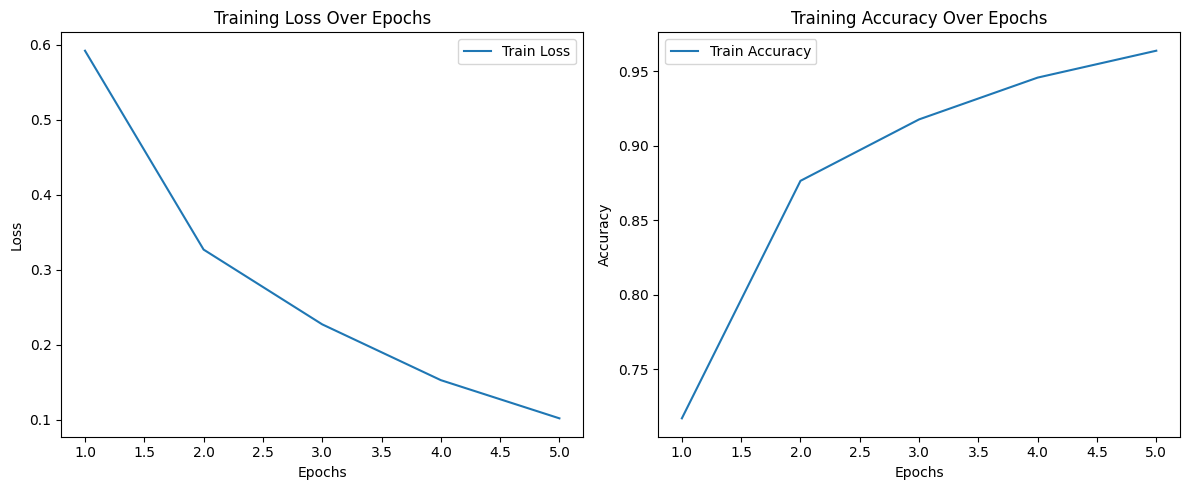

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
LSTM_save_path = "D:\\BSES - Data Analyst\\Sentiment Analysis\Model\\LSTM.pt"
torch.save(model.state_dict(), LSTM_save_path)

In [44]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluation', unit='batch'):
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total}')

Evaluation: 100%|██████████| 163/163 [00:38<00:00,  4.18batch/s]

Accuracy: 0.8956948858711355


In [10]:
new_texts = [
    "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se",
    "light aa gyi and customer service bhi bohot aachi thi aapki",
    "Fuck off asshole"
]

In [12]:
model_path = "D:\\BSES - Data Analyst\\Sentiment Analysis\Models\\LSTM.pt"
model_LSTM = SentimentClassifier(vocab_size, embed_dim, hidden_dim, num_layers, output_dim, dropout_rate)
model_LSTM.load_state_dict(torch.load(model_path))
model_LSTM.eval()

SentimentClassifier(
  (embedding): Embedding(400000, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (attention): Attention(
    (attention): Linear(in_features=100, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [13]:
def predict_sentiment_LSTM(text):
    text = clean_text(text)
    tokens = tokenize_text(text)
    padded_tokens = tokens[:max_len] + [0] * (max_len - len(tokens))
    input_tensor = torch.tensor(padded_tokens, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        output = model_LSTM(input_tensor)
        _, predicted = torch.max(output, 1)
    return label_encoder.inverse_transform(predicted.numpy())[0]

In [15]:
for text in new_texts:
    sentiment = predict_sentiment_LSTM(text)
    print(f'Text: "{text}"\nPredicted Sentiment: {sentiment}\n')

Text: "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se"
Predicted Sentiment: neutral

Text: "light aa gyi and customer service bhi bohot aachi thi aapki"
Predicted Sentiment: positive

Text: "Fuck off asshole"
Predicted Sentiment: neutral



# XLM-RoBERTa Model

In [16]:
model_name_RoBERTa = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
custom_cache_dir = os.path.join(os.getcwd(), 'Models')
os.makedirs(custom_cache_dir, exist_ok=True)
tokenizer_xlm_roberta = AutoTokenizer.from_pretrained(model_name_RoBERTa, cache_dir=custom_cache_dir)
model_xlm_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_RoBERTa, cache_dir=custom_cache_dir)

In [48]:
def predict_sentiment_XLMRoBERTa(text):
    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

    inputs = tokenizer_xlm_roberta(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model_xlm_roberta(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(predictions, dim=1).item()
    sentiment_label = sentiment_mapping[sentiment]

    return sentiment_label

In [66]:
temp = test_data
temp['Predicted_sentiment'] = temp['Customer_Text'].apply(predict_sentiment_XLMRoBERTa)
temp

In [90]:
accuracy = accuracy_score(temp['Sentiment'], test_data['Predicted_sentiment'])
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.783215427851536


In [49]:
new_texts = [
    "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se",
    "light aa gyi and customer service bhi bohot aachi thi aapki",
    "Fuck off asshole"
]

In [50]:
sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

for text in new_texts:
    sentiment = predict_sentiment_XLMRoBERTa(text)
    print(f'Text: "{text}"\nPredicted Sentiment: {sentiment}\n')

Text: "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se"
Predicted Sentiment: negative

Text: "light aa gyi and customer service bhi bohot aachi thi aapki"
Predicted Sentiment: positive

Text: "Fuck off asshole"
Predicted Sentiment: negative



# BERT Model

In [21]:
model_name_BERT = 'nlptown/bert-base-multilingual-uncased-sentiment'
custom_cache_dir = os.path.join(os.getcwd(), 'Models')
os.makedirs(custom_cache_dir, exist_ok=True)
tokenizer_BERT = BertTokenizer.from_pretrained(model_name_BERT, cache_dir=custom_cache_dir)
model_BERT = BertForSequenceClassification.from_pretrained(model_name_BERT, cache_dir=custom_cache_dir)

In [69]:
def predict_sentiment_BERT(text):
    sentiment_lower = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}

    sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

    inputs = tokenizer_BERT(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model_BERT(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(predictions, dim=1).item()
    sentiment_label = sentiment_mapping[sentiment_lower[sentiment]]

    return sentiment_label

In [120]:
temp = test_data
temp['Predicted_sentiment'] = temp['Customer_Text'].apply(predict_sentiment_XLMRoBERTa)
temp

,Customer_Text,Sentiment,Predicted_sentiment,Predicted_sentiment_label
11980,no current,1,1,neutral
11637,your person came and said there is electricity...,0,0,negative
3939,no electricity from 11 am todays morningplease...,0,0,negative
9634,sir hmare pass online bill aaya tha 2920 or 4t...,2,2,positive
4499,no update received regarding revised bill,1,1,neutral
...,...,...,...,...
33824,i i am the resident of ashoka pahari near chow...,0,0,negative
32960,bill of ca no 154310469 jan24 of rs3600 due on...,1,1,neutral
16891,please re send bill today updated please bill ...,1,1,neutral
10466,amount has not been credited yet kindly update...,0,1,neutral


In [121]:
accuracy = accuracy_score(temp['Sentiment'], temp['Predicted_sentiment'])
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.7827308847756566


In [70]:
new_texts = [
    "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se",
    "light aa gyi and customer service bhi bohot aachi thi aapki",
    "Fuck off asshole"
]

In [71]:
for text in new_texts:
    sentiment = predict_sentiment_BERT(text)
    print(f'Text: "{text}"\nPredicted Sentiment: {sentiment}\n')

Text: "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se"
Predicted Sentiment: negative

Text: "light aa gyi and customer service bhi bohot aachi thi aapki"
Predicted Sentiment: neutral

Text: "Fuck off asshole"
Predicted Sentiment: negative



# Final Prediction

In [72]:
def get_majority_label(predictions):
    counter = Counter(predictions)
    majority_label = counter.most_common(1)[0][0]
    return majority_label

In [83]:
new_texts = [
    "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se",
    "light aa gyi and customer service bhi bohot aachi thi aapki",
    "Fuck off asshole",
    "Aap toh bht aache ho sir, aapne jo bola tha vaise hi kara saab"
]

In [84]:
predictions = []

for text in new_texts:
    prediction_LSTM = predict_sentiment_LSTM(text)
    prediction_XLMRoBERTa1 = predict_sentiment_XLMRoBERTa(text)
    prediction_XLMRoBERTa2 = predict_sentiment_XLMRoBERTa(text)
    prediction_BERT = predict_sentiment_BERT(text)
    predictions.append((text, prediction_LSTM, prediction_XLMRoBERTa1, prediction_XLMRoBERTa2, prediction_BERT))

In [85]:
for entry in predictions:
    sentiment = get_majority_label(entry[1:])
    print(f'Text: "{entry[0]}"\nPredicted Sentiment: {sentiment}\n')

Text: "Mere ghar ki light nhi aa rahi hai, pichle 5-6 ghante se"
Predicted Sentiment: negative

Text: "light aa gyi and customer service bhi bohot aachi thi aapki"
Predicted Sentiment: positive

Text: "Fuck off asshole"
Predicted Sentiment: negative

Text: "Aap toh bht aache ho sir, aapne jo bola tha vaise hi kara saab"
Predicted Sentiment: negative

